# Multiplot corresponding training and label chips


Import packages

In [8]:
from PIL import Image as PILImage
import os
#import evaluate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
#from patchify import patchify
from datasets import load_dataset, DatasetDict, Dataset, Image as HFImage
from sklearn.model_selection import train_test_split
from osgeo import gdal
import glob
import math

/explore/nobackup/people/pmontesa/.nccstmp/ipykernel_1241173/3990555122.py:7: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [9]:
from matplotlib.colors import LinearSegmentedColormap
forest_ht_cmap = LinearSegmentedColormap.from_list('forest_ht', ['#636363','#fc8d59','#fee08b','#ffffbf','#d9ef8b','#91cf60','#1a9850','#005a32'], 12)

In [10]:
# gdf_chips_ifsar = gpd.read_file('/explore/nobackup/people/mmacande/srlite/chm_model/20231014_chm/chips_df_ifsar_chm_nodtm_v20231014.gpkg')
# gdf_chips_lidar = gpd.read_file('/explore/nobackup/people/mmacande/srlite/chm_model/20231014_chm/chips_df_lidar_nodtm_v20231014.gpkg')

# chips_gdf = pd.concat([gdf_chips_ifsar, gdf_chips_lidar])

In [11]:
# chips_gdf.shape

In [12]:
# chips_gdf[chips_gdf.outPrefix == 'train'].shape

## Read in the chips footprints

from `code/above-shrubs/notebooks/training_chips_final_set.ipynb`

In [17]:
chips_train = gpd.read_file('/home/pmontesa/ABoVE_Shrubs/footprints/footprints_chm_chips_lidar_include_train.gpkg')
chips_test =  gpd.read_file('/home/pmontesa/ABoVE_Shrubs/footprints/footprints_chm_chips_lidar_include_test.gpkg')
chips_val =   gpd.read_file('/home/pmontesa/ABoVE_Shrubs/footprints/footprints_chm_chips_lidar_include_val.gpkg')

In [21]:
gdf_chips_lidar = pd.concat([chips_train, chips_test, chips_val])

In [22]:
gdf_chips_lidar.shape

(230283, 25)

In [23]:
gdf_chips_lidar.iloc[0]

baseName                         WV02_20190830_M1BS_10300100966ED400
chipName           chip_WV02_20190830_M1BS_10300100966ED400_CHM_f...
outPrefix                                                      train
srlitePath         /explore/nobackup/projects/above/misc/ABoVE_Sh...
chmPath            /explore/nobackup/projects/dem/AK_IFSAR/dggs.a...
groupName                                   lidar_78_train_v20231006
chipStatus                                             Chip exported
predictor_isNA                                                   0.0
ifsar_chm_isNA                                                   NaN
source_type                                                    lidar
lidar_chm_min                                               0.030489
lidar_chm_p50                                               0.502715
lidar_chm_p90                                               4.472227
lidar_chm_p98                                              12.088588
lidar_chm_max                     

# Map lidar chips

In [1]:
#gdf_chips_lidar[-10:].explore(column='max', cmap='Spectral_r', tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}", attr="Esri")

In [13]:
def rescale_abs_clip(array, MIN_MAX_LIST=[(0, 6000),(0, 2000),(0, 2000)]):
    '''Re-scales data values of an array to absolute min and max values'''
    # Apply limits by clipping the data
    b1 = np.clip(array[0,:,:], *MIN_MAX_LIST[0])
    b2 = np.clip(array[1,:,:], *MIN_MAX_LIST[1])
    b3 = np.clip(array[2,:,:], *MIN_MAX_LIST[2])
    clip_arr = np.stack((
        (b1 - MIN_MAX_LIST[0][0]) / (MIN_MAX_LIST[0][1] - MIN_MAX_LIST[0][0]),
        (b2 - MIN_MAX_LIST[1][0]) / (MIN_MAX_LIST[1][1] - MIN_MAX_LIST[1][0]),
        (b3 - MIN_MAX_LIST[2][0]) / (MIN_MAX_LIST[2][1] - MIN_MAX_LIST[2][0])
    ))
    return clip_arr

In [14]:
def multiplot_corresponding(image_paths_train, label_paths_train, idx_start, n_increment, MIN_MAX_LIST=[(250, 1500),(250, 1500),(1000, 5000)], SHOW_TITLE=False, MIN_CHM=0.25, MAX_CHM=3):
    
    # # Your two lists of images
    image_paths_train_subset = image_paths_train[idx_start:idx_start+n_increment]
    label_paths_train_subset = label_paths_train[idx_start:idx_start+n_increment]

    n = len(image_paths_train_subset)
    j = 5  # Number of pairs per row (adjust as needed)

    # Calculate the required number of rows
    num_rows = math.ceil(n / j)
    num_cols = 2 * j  # Each pair needs 2 columns

    # Create a figure with appropriate dimensions
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10*j, 4.5*num_rows), sharex=True, sharey=True) 

    # Loop through all image pairs
    for i in range(n):
        row_idx = i // j
        col_idx = (i % j) * 2  # Multiply by 2 because each pair uses 2 columns

        # Handle both 1D and 2D axes arrays correctly
        if num_rows == 1:
            ax1 = axes[col_idx]
            ax2 = axes[col_idx + 1]
        else:
            ax1 = axes[row_idx, col_idx]
            ax2 = axes[row_idx, col_idx + 1]

        # FIRST IMAGE (LEFT) - RGB visualization
        file_path = image_paths_train_subset[i]
        
        try:
            data = np.load(file_path)

            rgb_array = data[1:4, :, :]

            image_normalized = rescale_abs_clip(rgb_array, MIN_MAX_LIST=MIN_MAX_LIST)
            image_normalized = np.transpose(image_normalized, (1, 2, 0))
            image_normalized = image_normalized[:, :, [2, 1, 0]]

            # Get filename for display
            rgb_filename = os.path.basename(file_path)

            ######################
            # Display the RGB image on the LEFT subplot
            im1 = ax1.imshow(image_normalized)
            if SHOW_TITLE:
                ax1.set_title(f'{rgb_filename}', fontsize=6.5)
            ax1.axis('on')

            # Calculate statistics for annotation
            min_rgb = np.min(rgb_array)
            max_rgb = np.max(rgb_array)
            mean_rgb = np.mean(rgb_array)

            # Add text annotation with statistics
            stats_text = f"RGB shape: {rgb_array.shape}\nMin: {min_rgb:.2f}\nMax: {max_rgb:.2f}\nMean: {mean_rgb:.2f}"
            props = dict(boxstyle='round', facecolor='white', alpha=0.7)
            ax1.text(0.05, 0.95, stats_text, transform=ax1.transAxes, fontsize=8,
                    verticalalignment='top', bbox=props)
            ax1.grid(True, alpha=0.3)


            # SECOND IMAGE (RIGHT) - Label visualization
            file_path = label_paths_train_subset[i]
            data = np.load(file_path)
            reshaped_data = data[0]

            # Get filename for display
            label_filename = os.path.basename(file_path)

            ######################
            # Display the label image on the RIGHT subplot
            im2 = ax2.imshow(image_normalized)

            im2 = ax2.imshow(np.ma.masked_where(reshaped_data < MIN_CHM, reshaped_data), cmap=forest_ht_cmap, vmin=MIN_CHM, vmax=MAX_CHM)
            if SHOW_TITLE:
                ax2.set_title(f'{label_filename}', fontsize=6.5)
            ax2.grid(True, alpha=0.3)

            # Add colorbar for the label image
            cbar = fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
            cbar.set_label('Height (m)')

            # Calculate statistics for annotation
            min_val = np.min(reshaped_data)
            max_val = np.max(reshaped_data)
            mean_val = np.mean(reshaped_data)
            median_val = np.median(reshaped_data)

            # Add text annotation with statistics
            stats_text = f"Min: {min_val:.2f}m\nMax: {max_val:.2f}m\nMean: {mean_val:.2f}m\nMedian: {median_val:.2f}m\nchm < {MIN_CHM} transparent"
            props = dict(boxstyle='round', facecolor='white', alpha=0.7)
            ax2.text(0.05, 0.95, stats_text, transform=ax2.transAxes, fontsize=8,
                    verticalalignment='top', bbox=props)

            #fig.suptitle("Corresponding Image and Label Pair", fontsize=16)
        except Exception as e:
            print(f"Cant load image chip: {file_path}")
            try:
                file_path = label_paths_train_subset[i]
                data = np.load(file_path)
                print(f"Label chip load fine.")
            except Exception as e:
                print(f"Cant load label chip either: {file_path}")
        
    # Turn off any unused subplots
    total_subplots = num_rows * num_cols
    for i in range(2*n, total_subplots):
        row_idx = i // num_cols
        col_idx = i % num_cols

        if num_rows == 1:
            axes[col_idx].axis('off')
            axes[col_idx].set_visible(False)
        else:
            axes[row_idx, col_idx].axis('off')
            axes[row_idx, col_idx].set_visible(False)

    plt.tight_layout()
    plt.show()

### Multiplot of corresponding images and labels

In [16]:
# image_paths_train = sorted(glob.glob('/explore/nobackup/people/mmacande/srlite/chm_model/20231014_chm/train_merged_nodtm_npy/images/*gliht*.npy'))
# label_paths_train = sorted(glob.glob('/explore/nobackup/people/mmacande/srlite/chm_model/20231014_chm/train_merged_nodtm_npy/labels/*gliht*.npy'))

In [17]:
label_paths_train = gpd.read_file('/home/pmontesa/ABoVE_Shrubs/footprints/footprints_chm_chips_lidar_include_train.gpkg').filename.to_list()
image_paths_train = [str(f).replace('labels','images') for f in label_paths_train]

In [18]:
len(label_paths_train)

153005

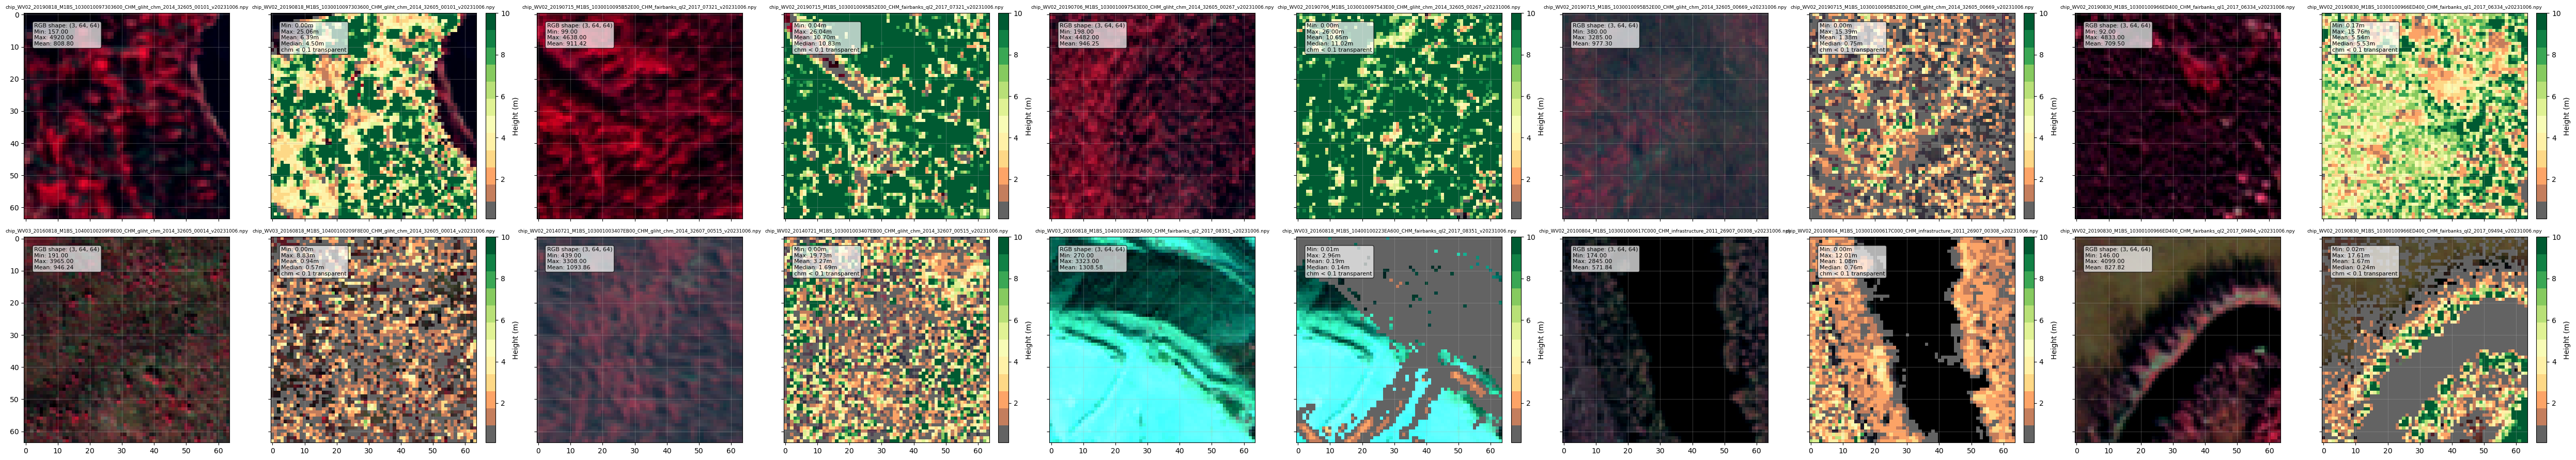

In [21]:
# This fits nicely on a slide (30 pairs arranged as 5 pairs per row
multiplot_corresponding(image_paths_train, label_paths_train, 230, 10, MIN_MAX_LIST=[(250, 1500),(250, 1500),(1000, 5000)], SHOW_TITLE=True, MIN_CHM=0.1, MAX_CHM=10)

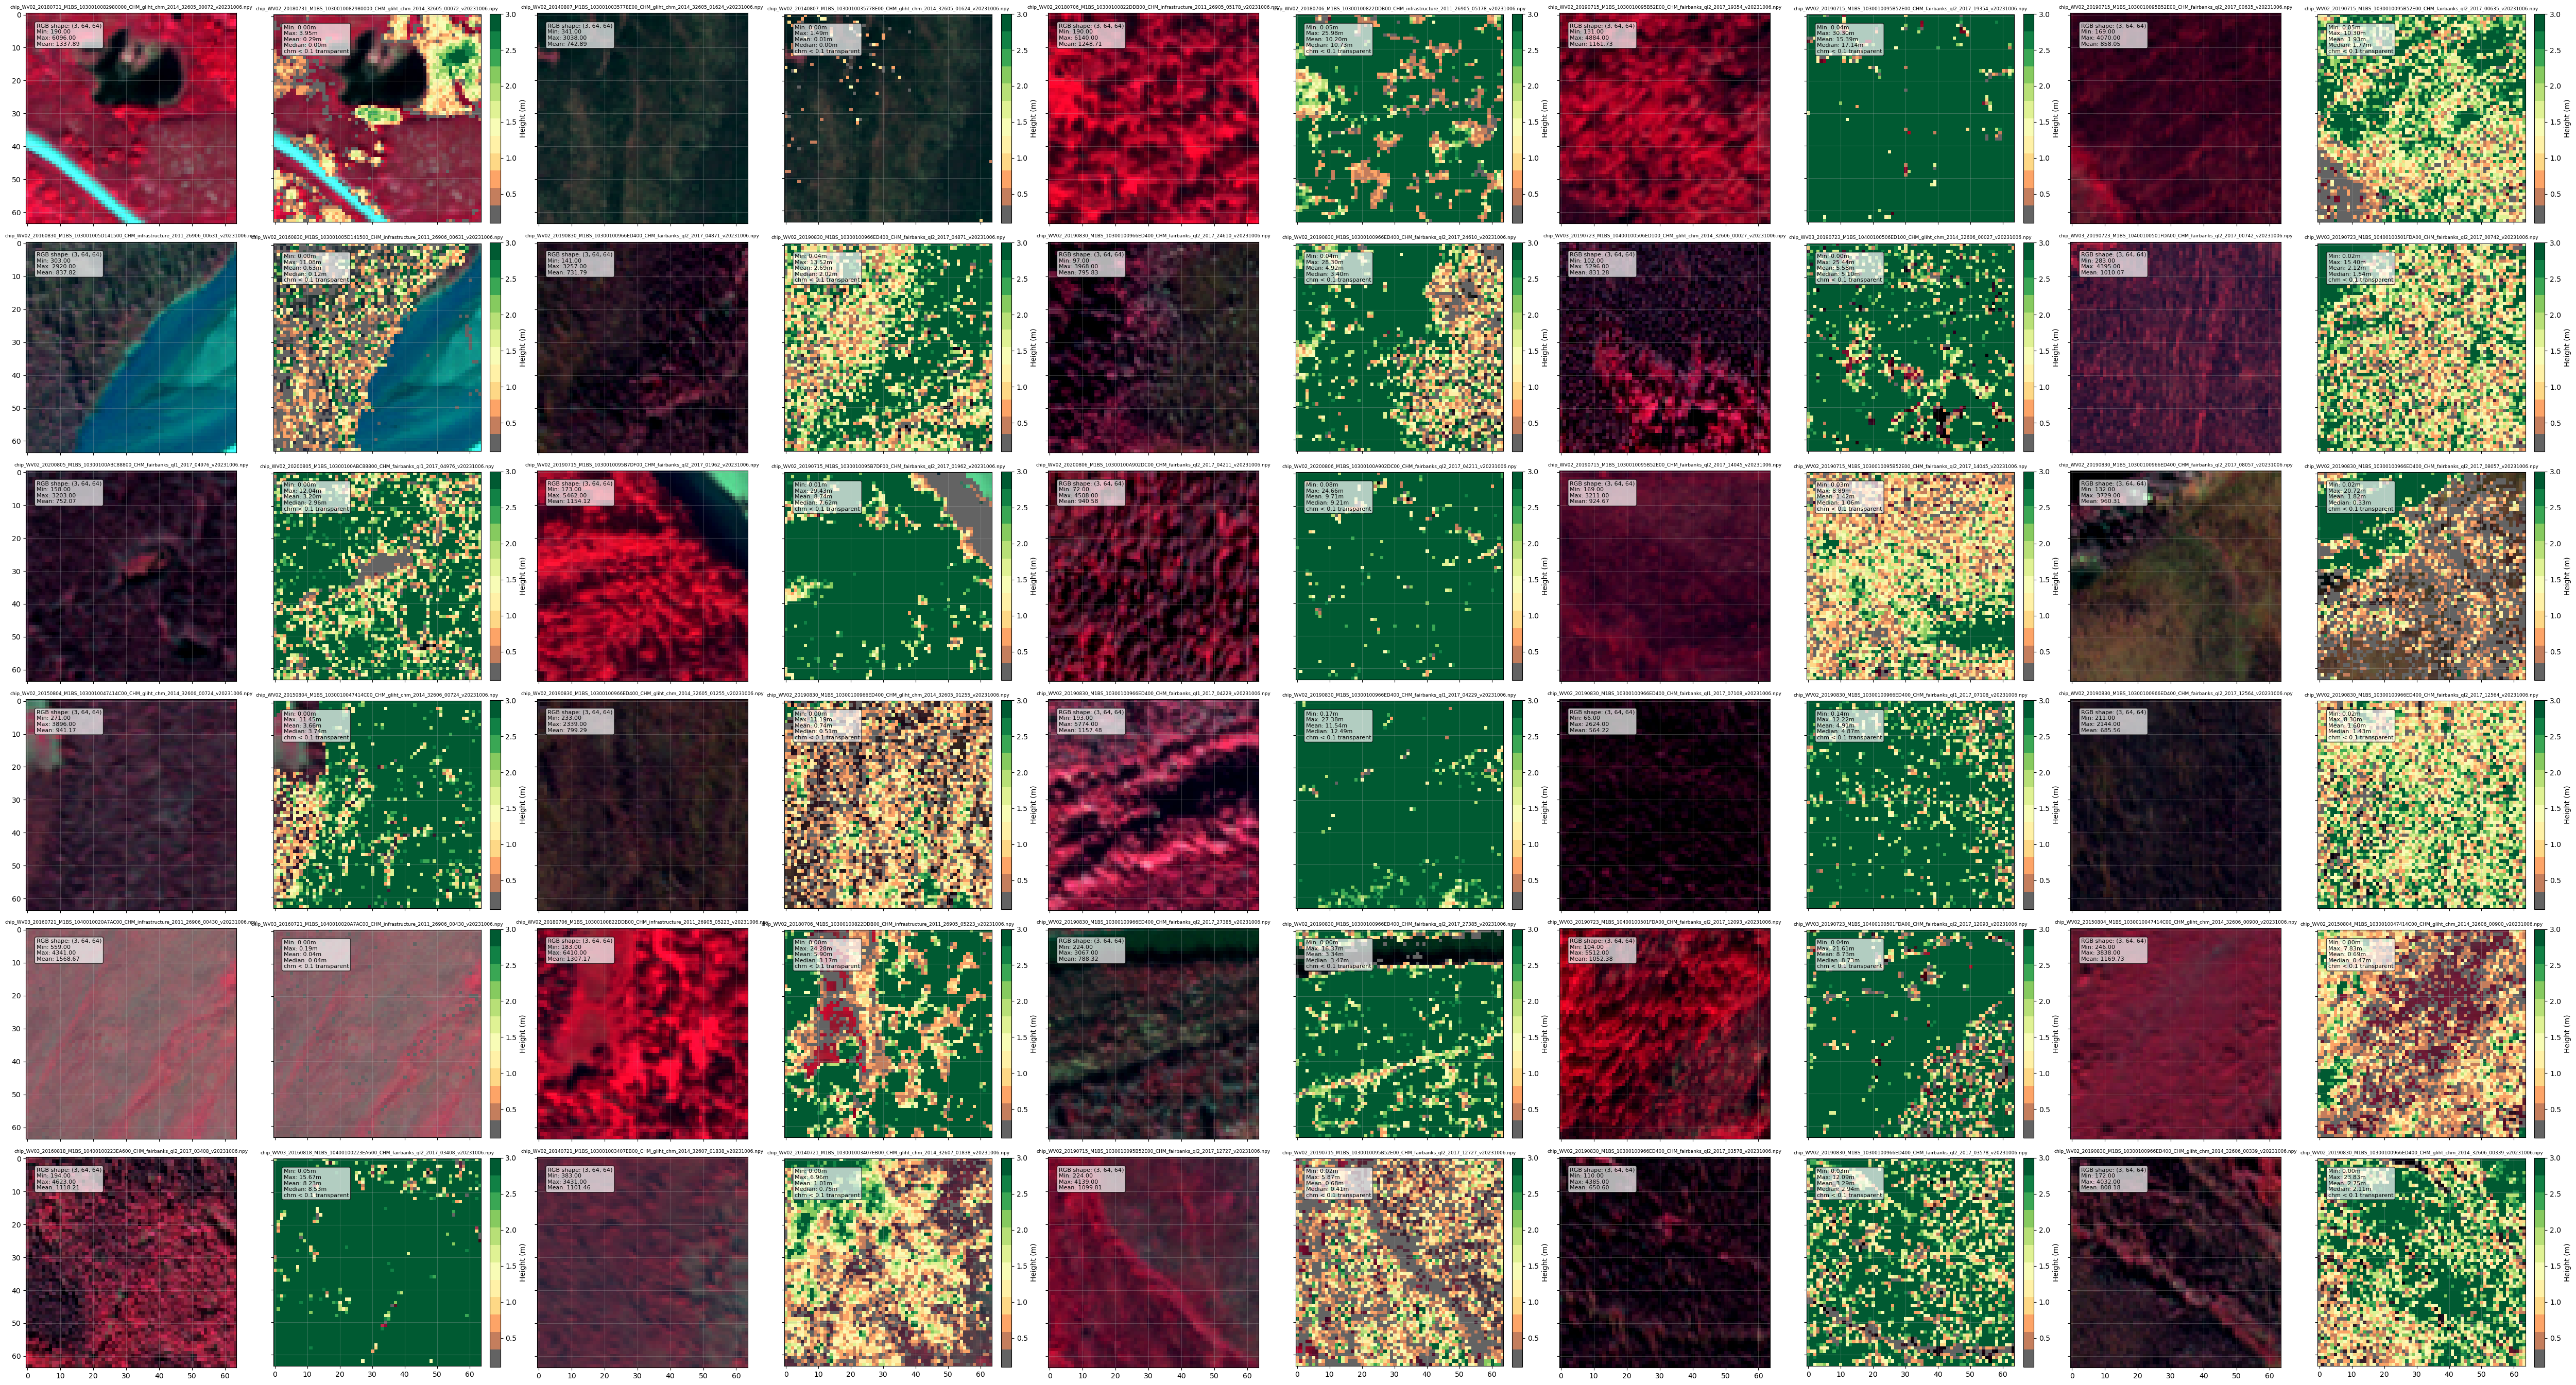

In [62]:
# This fits nicely on a slide (30 pairs arranged as 5 pairs per row
multiplot_corresponding(image_paths_train, label_paths_train, 250, 30, MIN_MAX_LIST=[(250, 1500),(250, 1500),(1000, 5000)], SHOW_TITLE=True, MIN_CHM=0.1)

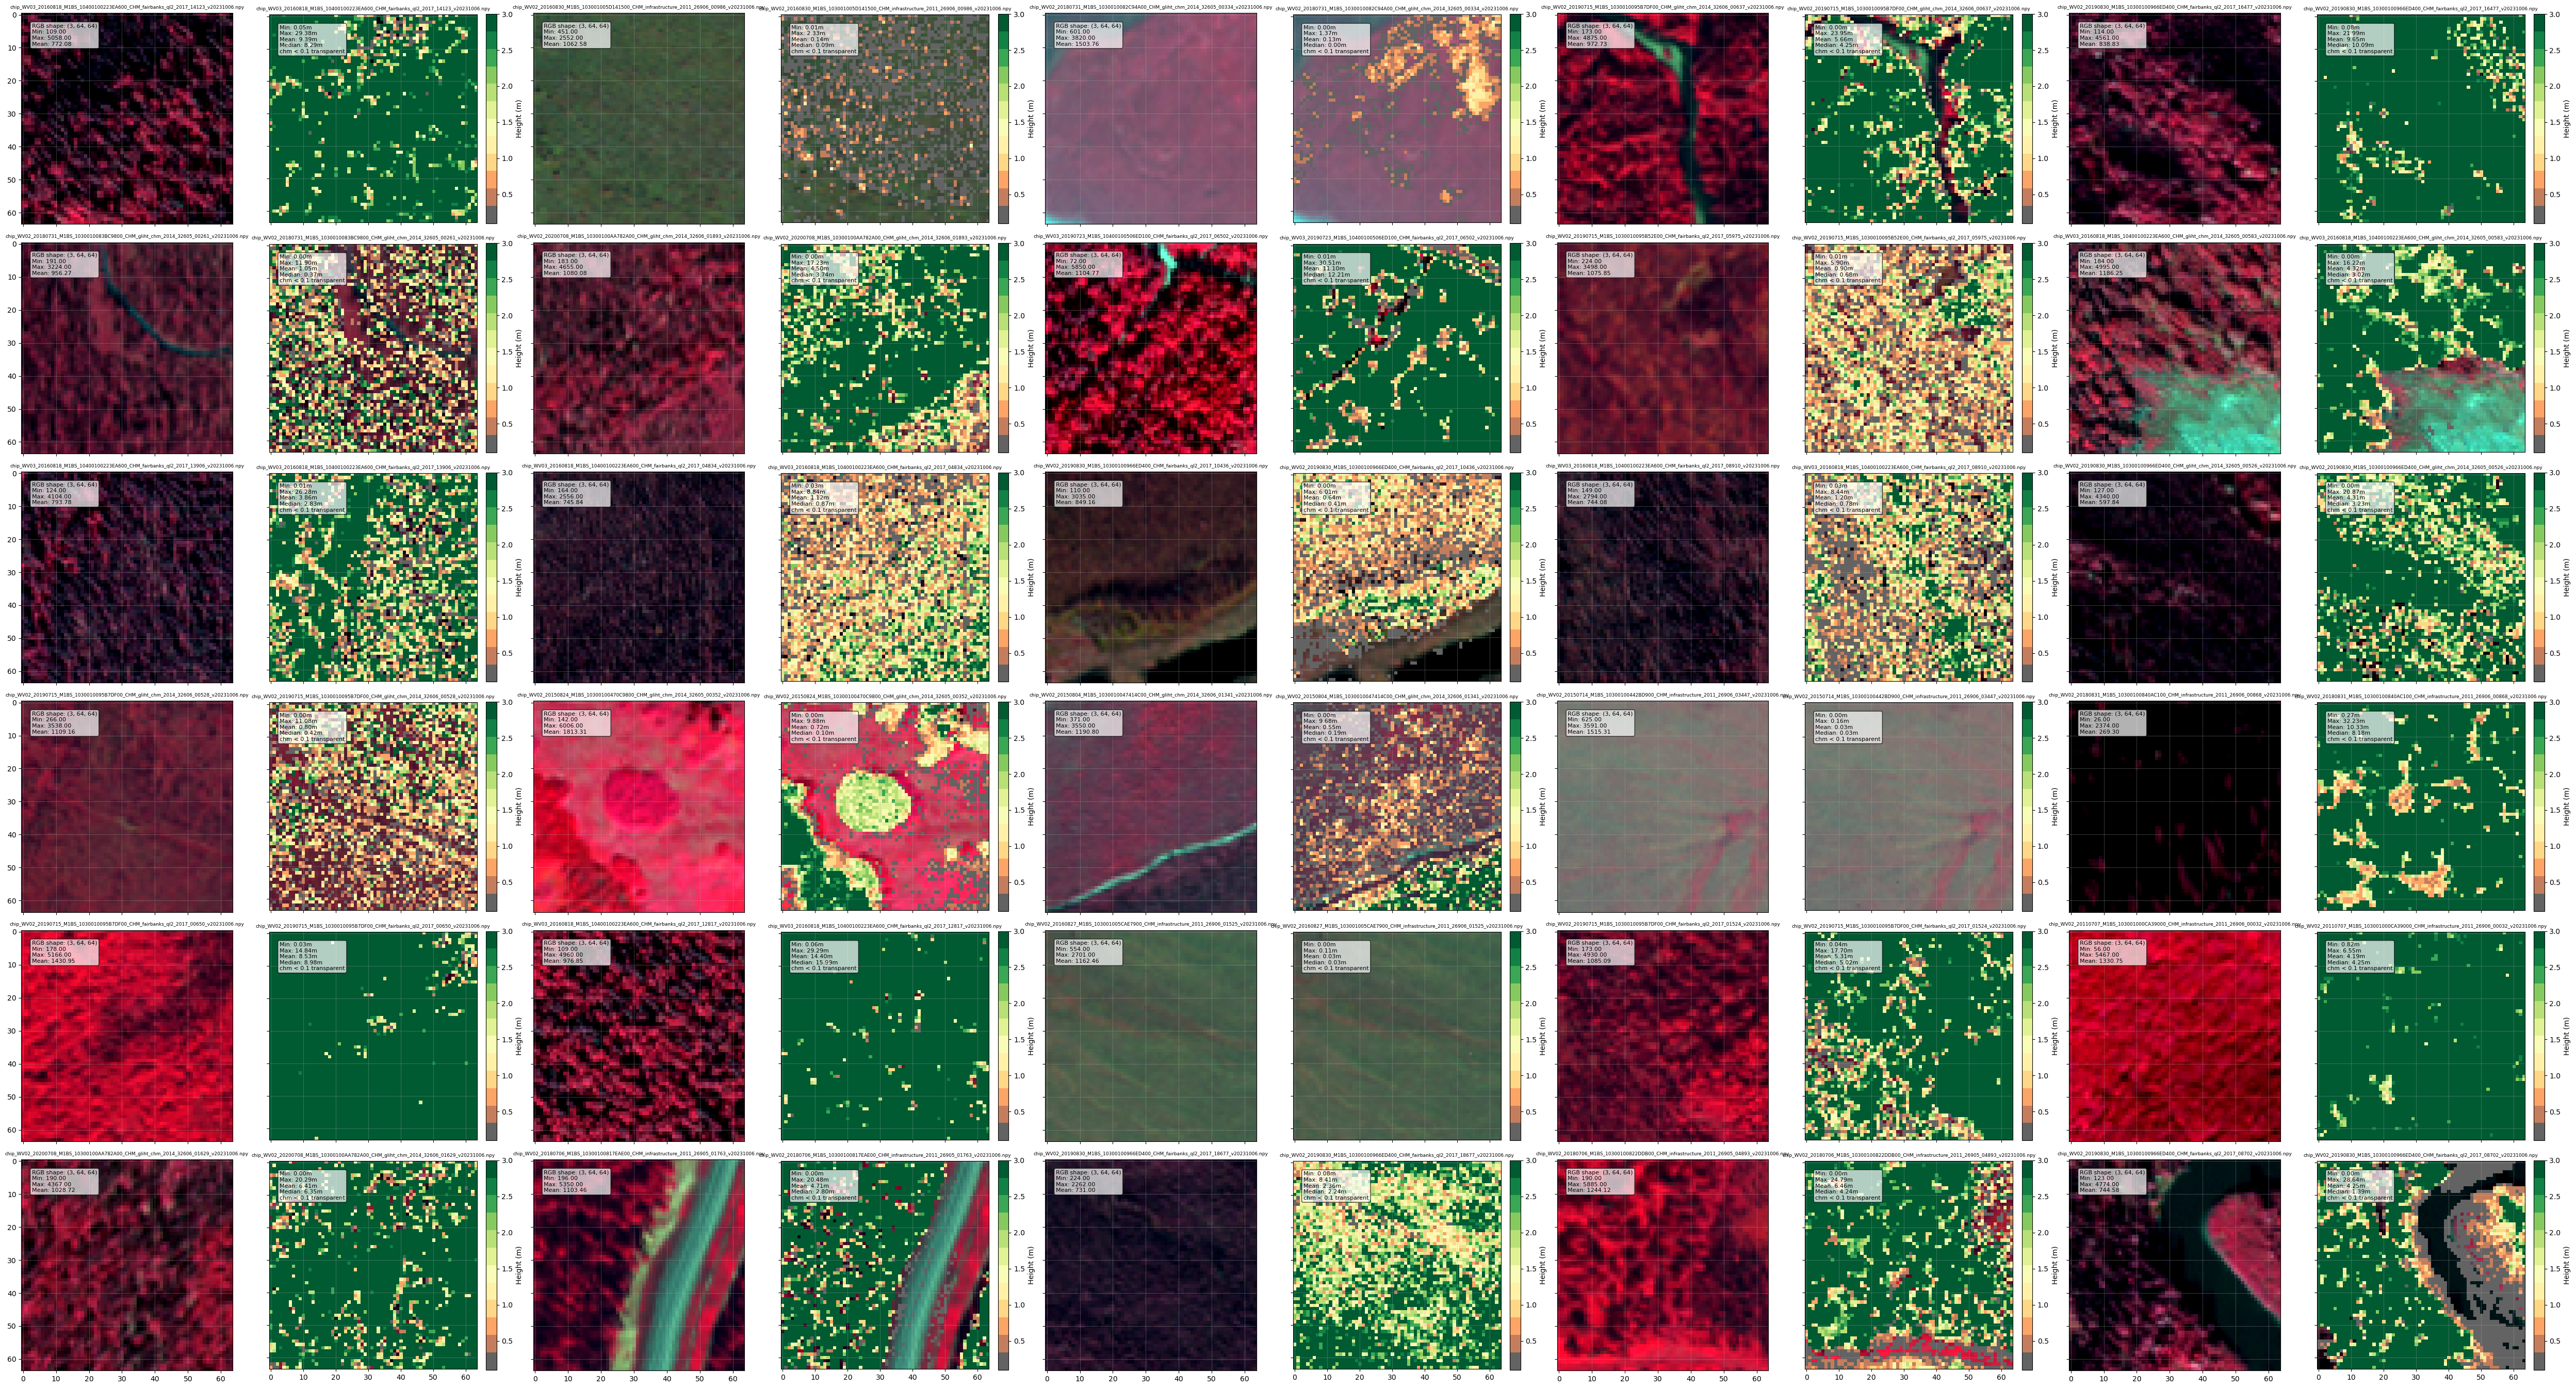

In [63]:
# This fits nicely on a slide (30 pairs arranged as 5 pairs per row
multiplot_corresponding(image_paths_train, label_paths_train, 500, 30, MIN_MAX_LIST=[(250, 1500),(250, 1500),(1000, 5000)], SHOW_TITLE=True, MIN_CHM=0.1)